# MOUNT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# then cp /content/drive/MyDrive/path/to/file.zip to /content and unzip


Mounted at /content/drive


# UNZIP


In [3]:
import os, zipfile
from collections import defaultdict

MAIN_ZIP = "/content/drive/MyDrive/EuroSAT_RGB (2).zip"  # main zip in Drive
TEMP_DIR = "/content/eurosat_temp"
EXTRACT_DIR = "/content/eurosat_data"

# 1. Extract the main zip (contains rgb.zip & ms.zip)
if not os.path.exists(TEMP_DIR):
    os.makedirs(TEMP_DIR, exist_ok=True)
    print(f"Extracting main zip: {MAIN_ZIP}")
    with zipfile.ZipFile(MAIN_ZIP, 'r') as zf:
        zf.extractall(TEMP_DIR)
else:
    print("Main zip already extracted.")

# 2. Locate rgb.zip inside
rgb_zip_path = None
for root, _, files in os.walk(TEMP_DIR):
    for f in files:
        if f.lower().endswith("rgb.zip"):
            rgb_zip_path = os.path.join(root, f)
            break
    if rgb_zip_path:
        break

if rgb_zip_path is None:
    raise FileNotFoundError("rgb.zip not found inside the main zip.")

# 3. Extract rgb.zip into EXTRACT_DIR
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    print(f"Extracting RGB dataset: {rgb_zip_path}")
    with zipfile.ZipFile(rgb_zip_path, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
else:
    print("RGB dataset already extracted.")

# 4. Summarize dataset
img_exts = {'.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp'}
class_counts = defaultdict(int)
sample_paths = []
MAX_SAMPLE_PRINT = 20

for dirpath, _, filenames in os.walk(EXTRACT_DIR):
    rel_path = os.path.relpath(dirpath, EXTRACT_DIR)
    if rel_path == ".":
        continue
    first_level = rel_path.split(os.sep)[0]
    for fname in filenames:
        if os.path.splitext(fname)[1].lower() in img_exts:
            class_counts[first_level] += 1
            if len(sample_paths) < MAX_SAMPLE_PRINT:
                sample_paths.append(os.path.join(dirpath, fname))

# Print summary
print("\n=== Dataset Summary (RGB) ===")
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count} images")
print(f"\nTotal images: {sum(class_counts.values())}")

print("\nSample files:")
for p in sample_paths:
    p


Main zip already extracted.


FileNotFoundError: rgb.zip not found inside the main zip.

**STEP 1: IMAGE PRE-PROCESSING**
# SCAN AND REMOVE CORRUPTED IMAGES

In [ ]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import shutil

# Paths
CLEANED_DIR = "/content/eurosat_cleaned"
os.makedirs(CLEANED_DIR, exist_ok=True)

# Use dataset root from Step 1
DATASET_ROOT = "/content/eurosat_data/EuroSAT_RGB"   # from previous cell

# Function to check if image is corrupted or blank
def is_image_corrupted(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return True
        # Check if all pixels are same (black or single color) → zero variance
        if np.var(img) == 0:
            return True
        return False
    except:
        return True

# Scan all images and copy only good ones
removed_count = 0
kept_count = 0
for class_name in tqdm(os.listdir(DATASET_ROOT)):
    class_path = os.path.join(DATASET_ROOT, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create class folder in cleaned dataset
    target_class_dir = os.path.join(CLEANED_DIR, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for fname in os.listdir(class_path):
        src_path = os.path.join(class_path, fname)
        if is_image_corrupted(src_path):
            removed_count += 1
            continue
        # Keep original for now
        shutil.copy(src_path, target_class_dir)
        kept_count += 1

print(f"Images kept: {kept_count}")
print(f"Images removed (corrupted/blank): {removed_count}")


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

Images kept: 27000
Images removed (corrupted/blank): 0


# RESIZE NORMALIZE AND APPLY GAUSSIAN FILTER

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os

RESIZED_DIR = "/content/eurosat_resized"
os.makedirs(RESIZED_DIR, exist_ok=True)

TARGET_SIZE = (64, 64)  # resize to 64x64

for class_name in tqdm(os.listdir(CLEANED_DIR)):
    class_path = os.path.join(CLEANED_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(RESIZED_DIR, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for fname in os.listdir(class_path):
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            continue

        # Ensure 3 channels (convert grayscale to RGB if needed)
        if len(img.shape) == 2:  # grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA → RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        # Resize
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # Apply Gaussian filter to reduce noise
        img_filtered = cv2.GaussianBlur(img_resized, (3, 3), 0)

        # Save as PNG
        save_path = os.path.join(target_class_dir, os.path.splitext(fname)[0] + ".png")
        cv2.imwrite(save_path, img_filtered)

print("✅ All images resized, converted to RGB PNG, and filtered.")


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

✅ All images resized, converted to RGB PNG, and filtered.


# VISUALIZE RANDOM SAMPLES


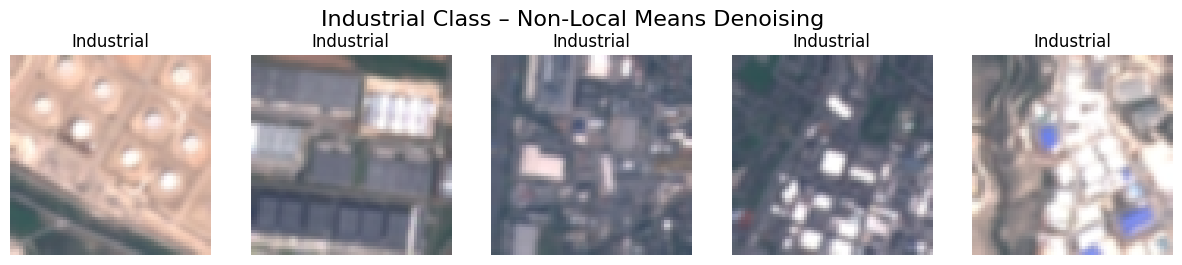

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the Industrial class
class_path = os.path.join( RESIZED_DIR, 'Industrial')

# Pick 5 random images
sample_imgs = random.sample(os.listdir(class_path), 5)

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Industrial")
    plt.axis('off')

plt.suptitle("Industrial Class – GAUSSIAN", fontsize=16)
plt.show()


# ALTERNATIVE FILTER (median filter)

In [ ]:
import cv2
import os
from tqdm import tqdm

RESIZED_MEDIAN_DIR = "/content/eurosat_resized_median"
os.makedirs(RESIZED_MEDIAN_DIR, exist_ok=True)

TARGET_SIZE = (64, 64)

for class_name in tqdm(os.listdir(CLEANED_DIR)):
    class_path = os.path.join(CLEANED_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(RESIZED_MEDIAN_DIR, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for fname in os.listdir(class_path):
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            continue

        # Ensure RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        # Resize
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # Apply Median filter (kernel size 3)
        img_filtered = cv2.medianBlur(img_resized, 3)

        # Save as PNG
        save_path = os.path.join(target_class_dir, os.path.splitext(fname)[0] + ".png")
        cv2.imwrite(save_path, img_filtered)

print("✅ All images resized, converted to RGB PNG, and filtered with Median filter.")


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]

✅ All images resized, converted to RGB PNG, and filtered with Median filter.


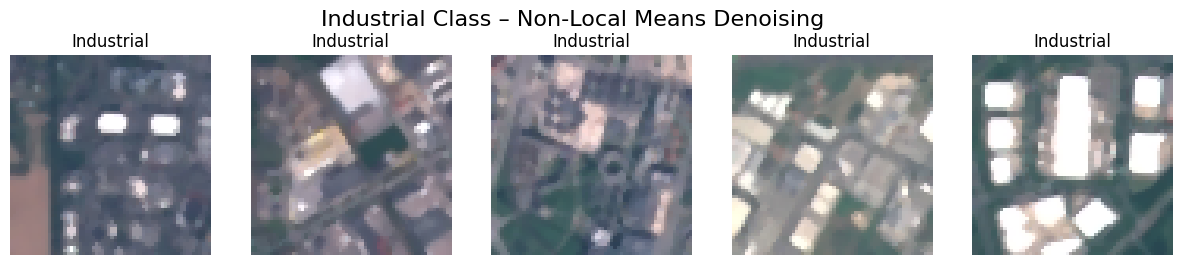

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the Industrial class
class_path = os.path.join( RESIZED_MEDIAN_DIR, 'Industrial')

# Pick 5 random images
sample_imgs = random.sample(os.listdir(class_path), 5)

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Industrial")
    plt.axis('off')

plt.suptitle("Industrial Class – median filter", fontsize=16)
plt.show()


BILATERAL FILTER ( EDGE- PRESERVING)

In [ ]:
RESIZED_BILATERAL_DIR = "/content/eurosat_resized_bilateral"
os.makedirs(RESIZED_BILATERAL_DIR, exist_ok=True)

TARGET_SIZE = (64, 64)

for class_name in tqdm(os.listdir(CLEANED_DIR)):
    class_path = os.path.join(CLEANED_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(RESIZED_BILATERAL_DIR, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for fname in os.listdir(class_path):
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            continue

        # Ensure RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        # Resize
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # Apply Bilateral filter
        img_filtered = cv2.bilateralFilter(img_resized, d=5, sigmaColor=75, sigmaSpace=75)

        # Save as PNG
        save_path = os.path.join(target_class_dir, os.path.splitext(fname)[0] + ".png")
        cv2.imwrite(save_path, img_filtered)

print("✅ Bilateral filter applied — preserves edges while reducing noise.")


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

✅ Bilateral filter applied — preserves edges while reducing noise.


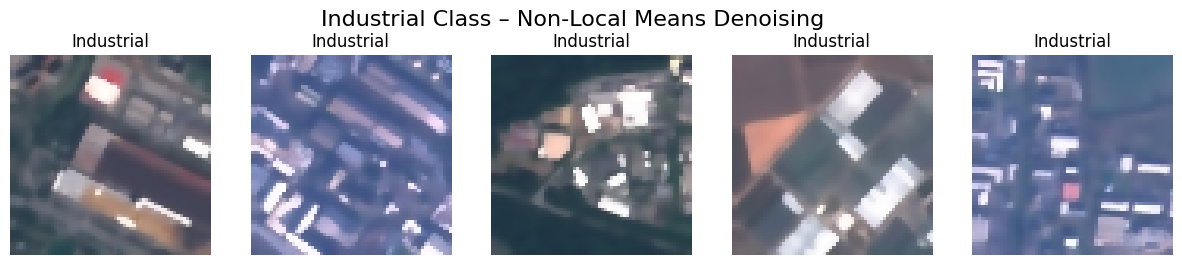

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the Industrial class
class_path = os.path.join( RESIZED_BILATERAL_DIR, 'Industrial')

# Pick 5 random images
sample_imgs = random.sample(os.listdir(class_path), 5)

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Industrial")
    plt.axis('off')

plt.suptitle("bilateral", fontsize=16)
plt.show()


# FINAL CLEANING WITH NON-LOCAL DENOISING

In [ ]:
RESIZED_NL_DIR = "/content/eurosat_resized_nlm"
os.makedirs(RESIZED_NL_DIR, exist_ok=True)

TARGET_SIZE = (64, 64)

for class_name in tqdm(os.listdir(CLEANED_DIR)):
    class_path = os.path.join(CLEANED_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(RESIZED_NL_DIR, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for fname in os.listdir(class_path):
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            continue

        # Ensure RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        # Resize
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # Apply Non-Local Means Denoising
        img_filtered = cv2.fastNlMeansDenoisingColored(img_resized, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

        # Save as PNG
        save_path = os.path.join(target_class_dir, os.path.splitext(fname)[0] + ".png")
        cv2.imwrite(save_path, img_filtered)

print("✅ Non-Local Means denoising applied — images cleaned with minimal loss of detail.")


100%|██████████| 10/10 [09:13<00:00, 55.37s/it]

✅ Non-Local Means denoising applied — images cleaned with minimal loss of detail.


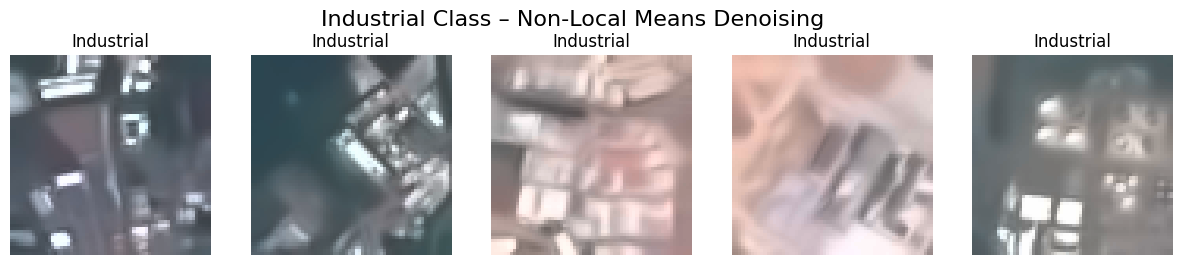

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the Industrial class
class_path = os.path.join(RESIZED_NL_DIR, 'Industrial')

# Pick 5 random images
sample_imgs = random.sample(os.listdir(class_path), 5)

plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Industrial")
    plt.axis('off')

plt.suptitle("Industrial Class – Non-Local Means Denoising", fontsize=16)
plt.show()


# COLOR HISTOGRAMS BEFORE AND AFTER

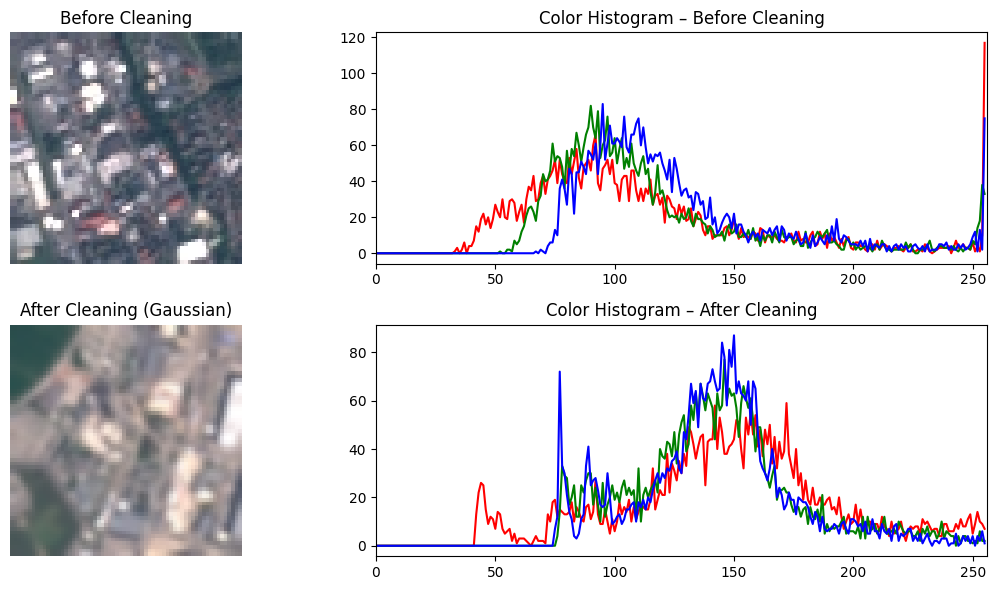

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# Paths
before_dir = os.path.join(CLEANED_DIR, "Industrial")   # unfiltered cleaned images
after_dir = os.path.join(RESIZED_DIR, "Industrial")    # Gaussian-filtered images

# Pick one sample image from the Industrial class
sample_before = os.path.join(before_dir, random.choice(os.listdir(before_dir)))
sample_after = os.path.join(after_dir, random.choice(os.listdir(after_dir)))

# Load images
img_before = cv2.imread(sample_before)
img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)

img_after = cv2.imread(sample_after)
img_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB)

# Function to compute histogram
def compute_histogram(image):
    colors = ('r', 'g', 'b')
    hist_data = []
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0,256])
        hist_data.append((hist, col))
    return hist_data

# Compute histograms
hist_before = compute_histogram(img_before)
hist_after = compute_histogram(img_after)

# Plot images and histograms
plt.figure(figsize=(12,6))

# Original image
plt.subplot(2,2,1)
plt.imshow(img_before)
plt.title("Before Cleaning")
plt.axis('off')

# Histogram before
plt.subplot(2,2,2)
for hist, col in hist_before:
    plt.plot(hist, color=col)
plt.title("Color Histogram – Before Cleaning")
plt.xlim([0,256])

# Cleaned image
plt.subplot(2,2,3)
plt.imshow(img_after)
plt.title("After Cleaning (Gaussian)")
plt.axis('off')

# Histogram after
plt.subplot(2,2,4)
for hist, col in hist_after:
    plt.plot(hist, color=col)
plt.title("Color Histogram – After Cleaning")
plt.xlim([0,256])

plt.tight_layout()
plt.show()


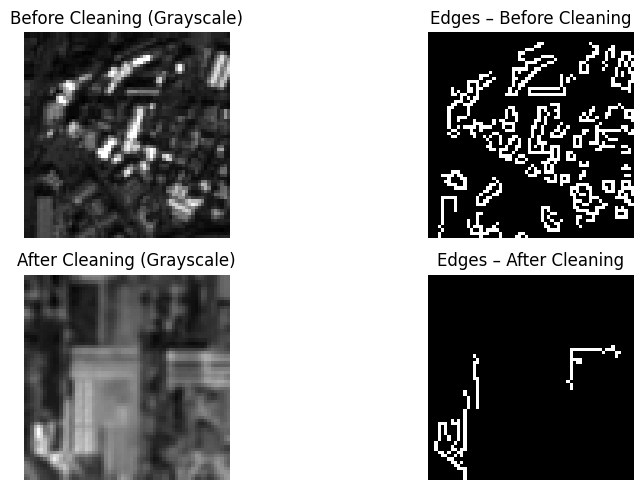

In [ ]:
# Paths
before_dir = os.path.join(CLEANED_DIR, "Industrial")   # unfiltered cleaned images
after_dir = os.path.join(RESIZED_DIR, "Industrial")    # Gaussian-filtered images

# Pick one sample image
sample_before = os.path.join(before_dir, random.choice(os.listdir(before_dir)))
sample_after = os.path.join(after_dir, random.choice(os.listdir(after_dir)))

# Load images as grayscale for edge detection
gray_before = cv2.imread(sample_before, cv2.IMREAD_GRAYSCALE)
gray_after = cv2.imread(sample_after, cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
edges_before = cv2.Canny(gray_before, 100, 200)
edges_after = cv2.Canny(gray_after, 100, 200)

# Visualize
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
plt.imshow(gray_before, cmap='gray')
plt.title("Before Cleaning (Grayscale)")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(edges_before, cmap='gray')
plt.title("Edges – Before Cleaning")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(gray_after, cmap='gray')
plt.title("After Cleaning (Grayscale)")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(edges_after, cmap='gray')
plt.title("Edges – After Cleaning")
plt.axis('off')

plt.tight_layout()
plt.show()


## **STEP 2: LOAD AND SPLIT DATA**


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tqdm import tqdm

# Dataset path (Gaussian filtered)
DATASET_PATH = "/content/eurosat_resized"

# Parameters
IMG_SIZE = (64, 64)

# Load images and labels
images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

print(f"Detected classes: {class_names}")

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
        labels.append(class_idx)

# Convert to NumPy arrays
images = np.array(images, dtype="float32") / 255.0  # normalize
labels = np.array(labels)

# One-hot encode labels
labels = to_categorical(labels, num_classes=len(class_names))

# Train-test split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Detected classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Loading SeaLake: 100%|██████████| 3000/3000 [00:00<00:00, 5796.72it/s]


Training set: (21600, 64, 64, 3), Validation set: (5400, 64, 64, 3)


# **STEP 3: CNN BASELINE MODEL**

In [ ]:
!pip install tensorflow

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,642 (4.87 MB)

 Trainable params: 1,276,682 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5294 - loss: 1.5271 - val_accuracy: 0.1656 - val_loss: 5.0868
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7414 - loss: 0.7604 - val_accuracy: 0.4722 - val_loss: 1.8410
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7841 - loss: 0.6224 - val_accuracy: 0.3028 - val_loss: 4.7858
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8217 - loss: 0.5256 - val_accuracy: 0.5031 - val_loss: 1.8735
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8380 - loss: 0.4609 - val_accuracy: 0.5606 - val_loss: 1.6452
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8596 - loss: 0.4001 - val_accuracy: 0.4906 - val_loss: 2.8678
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8673 - loss: 0.3738 - val_accuracy: 0.6789 - val_loss: 1.0572
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8741 - loss: 0.3578 - val_acc

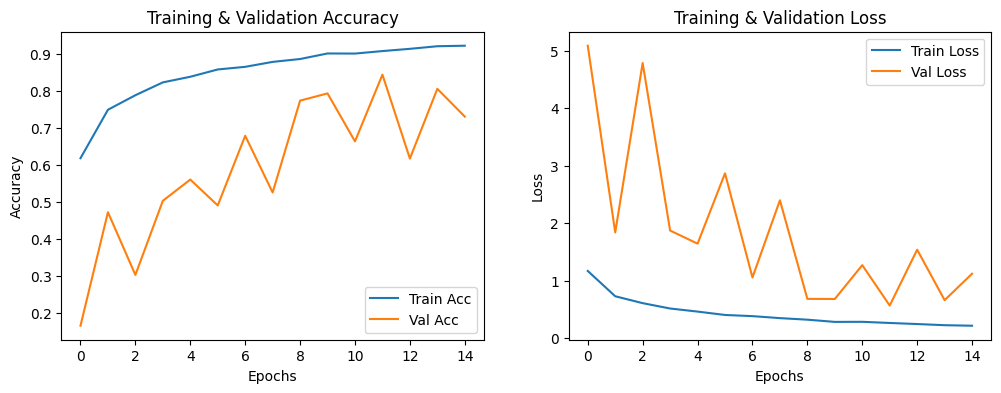

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define CNN model
model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Layer 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Layer 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Flatten & Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # output layer
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    verbose=1
)

# Plot accuracy & loss
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# **Step 4 – IMPROVED MODEL**

Epoch 1/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.4798 - loss: 1.6807 - val_accuracy: 0.1233 - val_loss: 6.2698 - learning_rate: 0.0010
Epoch 2/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 0.8622 - val_accuracy: 0.1172 - val_loss: 6.6853 - learning_rate: 0.0010
Epoch 3/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.7056 - loss: 0.8569 - val_accuracy: 0.2943 - val_loss: 3.0228 - learning_rate: 0.0010
Epoch 4/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7969 - loss: 0.7061 - val_accuracy: 0.2624 - val_loss: 3.2294 - learning_rate: 0.0010
Epoch 5/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.7514 - loss: 0.6925 - val_accuracy: 0.5557 - val_loss: 1.4978 - learning_rate: 0.0010
Epoch 6/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.5837 - val_accuracy: 0.5254 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 7/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.7726 - loss: 

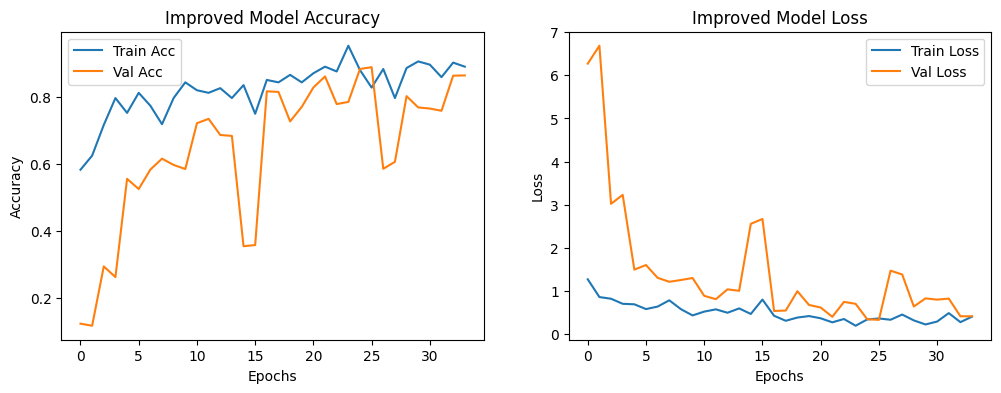

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



# Simplified data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Improved CNN architecture
improved_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile
improved_model.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train with augmentation
history_improved = improved_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# Plot accuracy & loss
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_improved.history['accuracy'], label='Train Acc')
plt.plot(history_improved.history['val_accuracy'], label='Val Acc')
plt.title("Improved Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Val Loss')
plt.title("Improved Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
improved_model.save("/content/drive/MyDrive/improved_model.h5")


# LOAD MODEL

In [ ]:
from tensorflow.keras.models import load_model
improved_model = load_model("/content/drive/MyDrive/improved_model.h5")


# ** STEP 5: EVALUATION**

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
=== Classification Report ===
                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.88      0.88       600
              Forest       0.92      0.98      0.95       600
HerbaceousVegetation       0.80      0.87      0.83       600
             Highway       0.82      0.91      0.86       500
          Industrial       0.96      0.94      0.95       500
             Pasture       0.96      0.74      0.84       400
       PermanentCrop       0.85      0.72      0.78       500
         Residential       0.90      0.98      0.94       600
               River       0.89      0.81      0.85       500
             SeaLake       0.94      0.99      0.96       600

            accuracy                           0.89      5400
           macro avg       0.89      0.88      0.88      5400
        weighted avg       0.89      0.89      0.89      5400



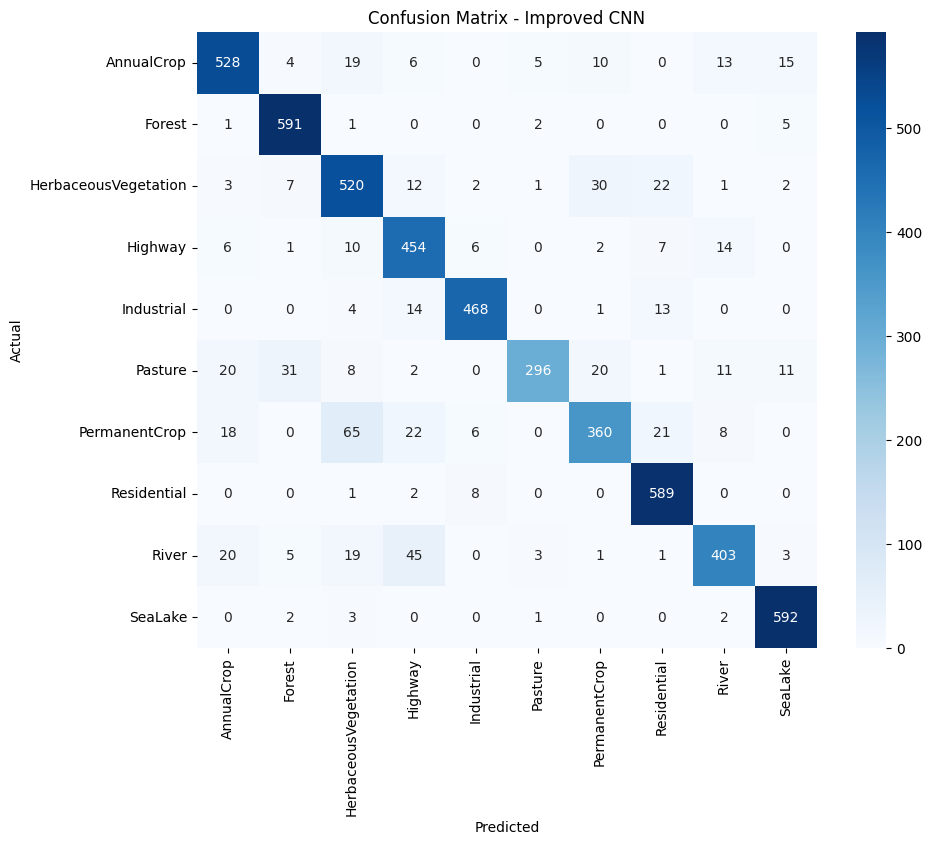


✅ Predictions saved to predictions.csv


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import numpy as np

# Predict class probabilities
y_pred_probs = improved_model.predict(X_val, verbose=1)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification report
print("=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Improved CNN")
plt.show()

# Save predictions to CSV
pred_df = pd.DataFrame({
    "image_id": range(len(y_pred_classes)),
    "predicted_label": [class_names[i] for i in y_pred_classes]
})
pred_df.to_csv("predictions.csv", index=False)

print("\n✅ Predictions saved to predictions.csv")
